# Predictive Modelling of Subscribers in Minecraft Server

Intro

Methods and Results code 

Can a player's total played hours and experience level, predict whether they subscribe to the game-related newsletter?


In [3]:
library(tidyverse)
library(tidymodels)

players <- read_csv("https://raw.githubusercontent.com/edoardo-antonucci/Data-Science-Project-Planning-Stage-Individual-/main/players.csv")
head(players)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ lubridate 1.9.3     ✔ stringr   1.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ readr::col_factor() masks scales::col_factor()
✖ purrr::discard()    masks scales::discard()
✖ dplyr::filter()     masks stats::filter()
✖ stringr::fixed()    masks recipes::fixed()
✖ dplyr::lag()        masks stats::lag()
✖ readr::spec()       masks yardstick::spec()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


In [4]:
players_tidy <- players |>
  select(experience, played_hours, subscribe) |>
  mutate(experience = as.factor(experience))

head(players_tidy)

experience,played_hours,subscribe
<fct>,<dbl>,<lgl>
Pro,30.3,TRUE
Veteran,3.8,TRUE
Veteran,0.0,FALSE
Amateur,0.7,TRUE
Regular,0.1,TRUE
Amateur,0.0,TRUE


In [23]:
players_summary <- summary(players_tidy)
players_summary


    experience  played_hours     subscribe  
 Amateur :63   Min.   :  0.000   FALSE: 52  
 Beginner:35   1st Qu.:  0.000   TRUE :144  
 Pro     :14   Median :  0.100              
 Regular :36   Mean   :  5.846              
 Veteran :48   3rd Qu.:  0.600              
               Max.   :223.100              

ERROR: Error in eval(expr, envir, enclos): object 'experience' not found


Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 85 rows containing non-finite outside the scale range (`stat_bin()`).”


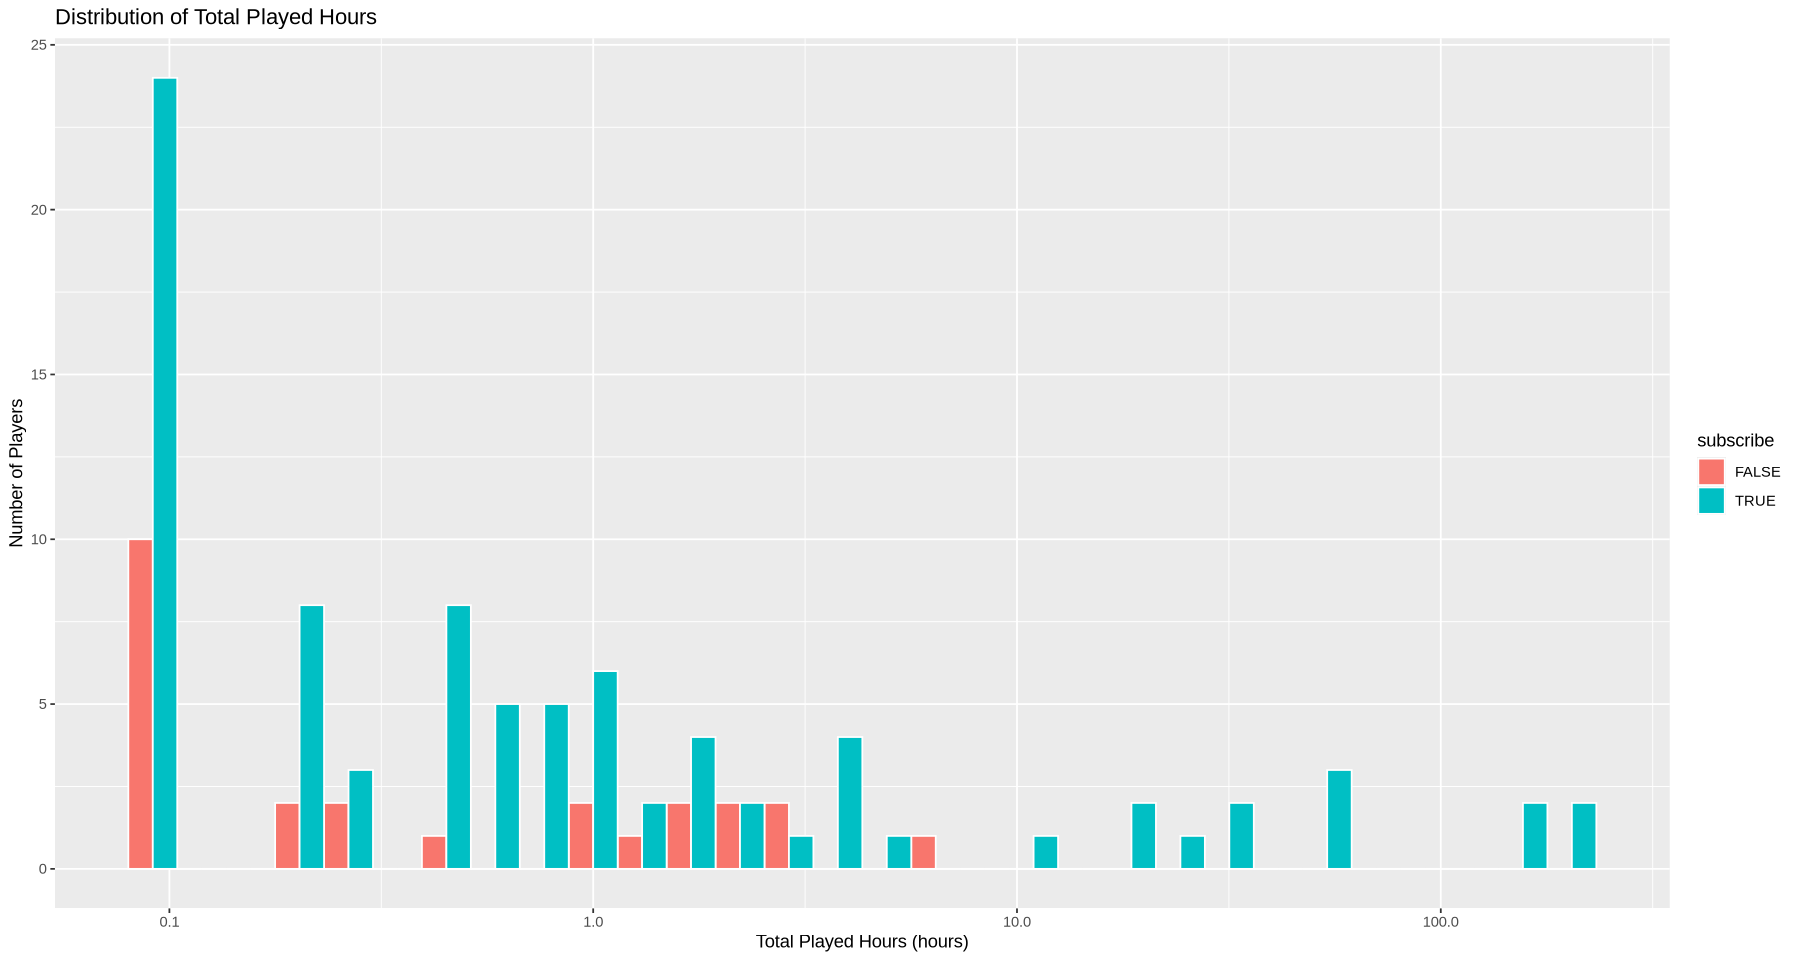

In [24]:
options (repr.plot.width = 15)

# Distribution of Total Played Hours
total_hours_plot <- ggplot(players_tidy, aes(x = played_hours, fill = subscribe)) +
  geom_histogram(color = "white",position = "dodge") +
  scale_x_log10 ()+
  labs(
    title = "Distribution of Total Played Hours",
    x = "Total Played Hours (hours)",
    y = "Number of Players", 
    fill = "subscribe"
  )
total_hours_plot

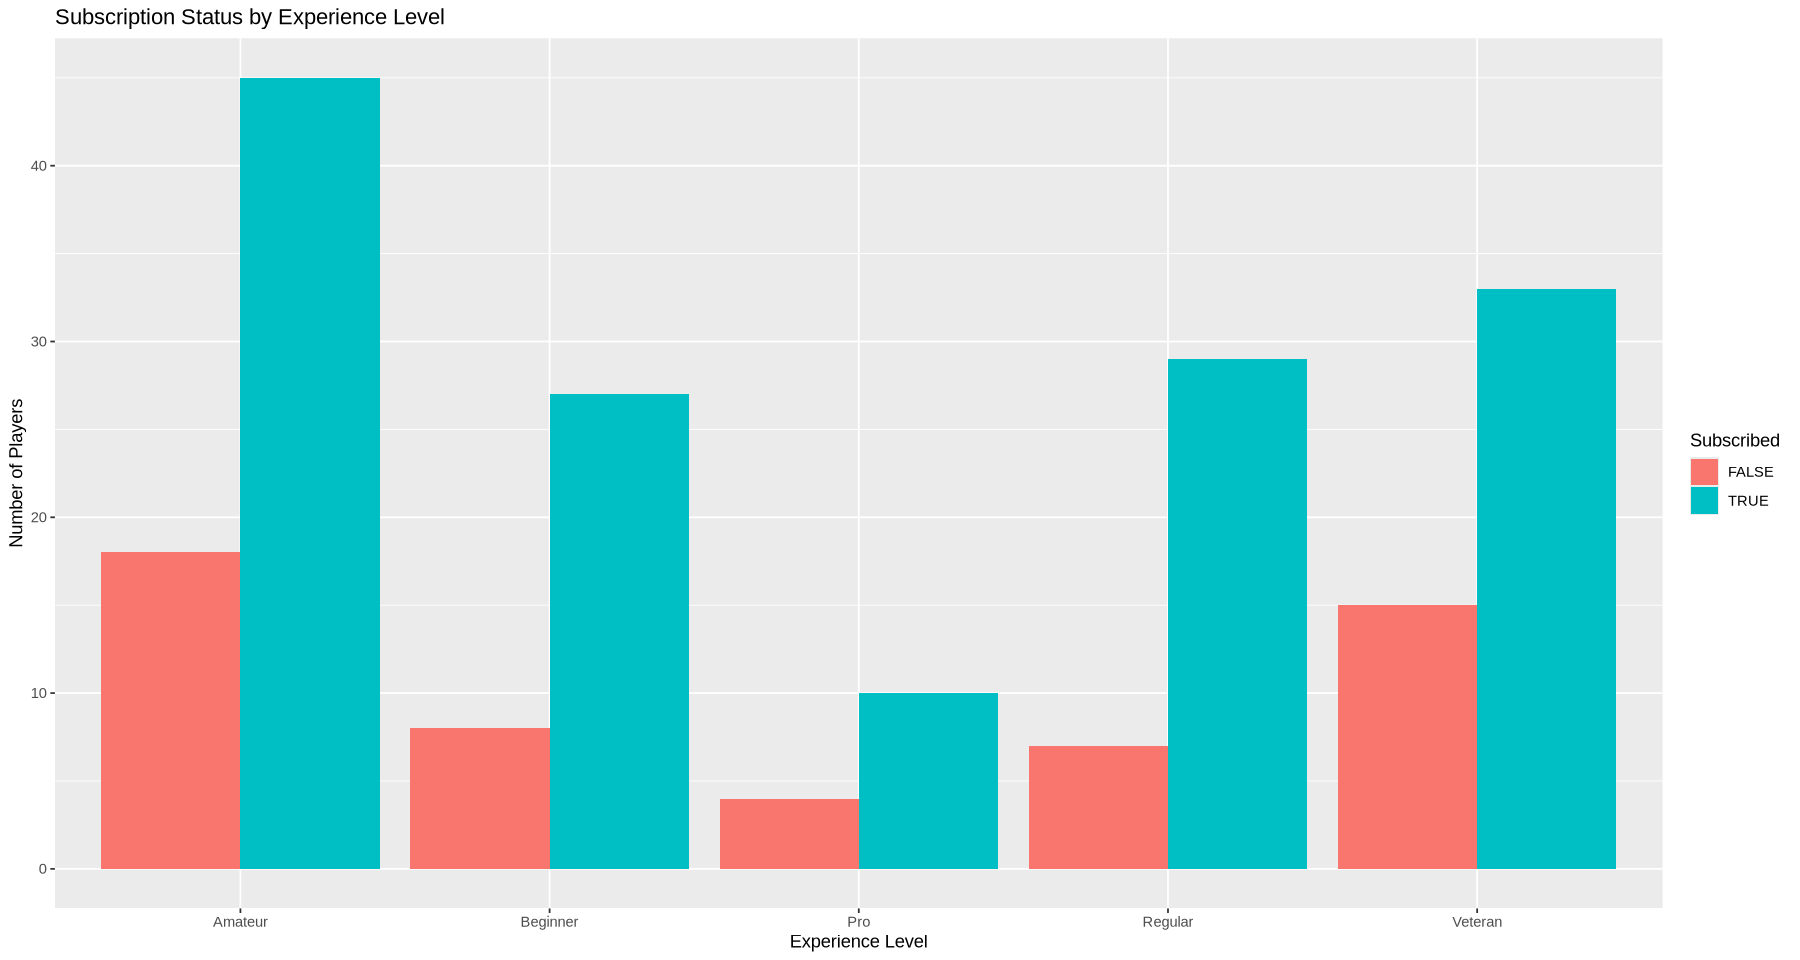

In [26]:
# Subscription status vs Experience Level
ph_vs_ns <- ggplot(players_tidy, aes(x = experience, fill = subscribe)) +
  geom_bar(position = "dodge") +
  labs(
    title = "Subscription Status by Experience Level",
    x = "Experience Level",
    y = "Number of Players",
    fill = "Subscribed"
  )
ph_vs_ns

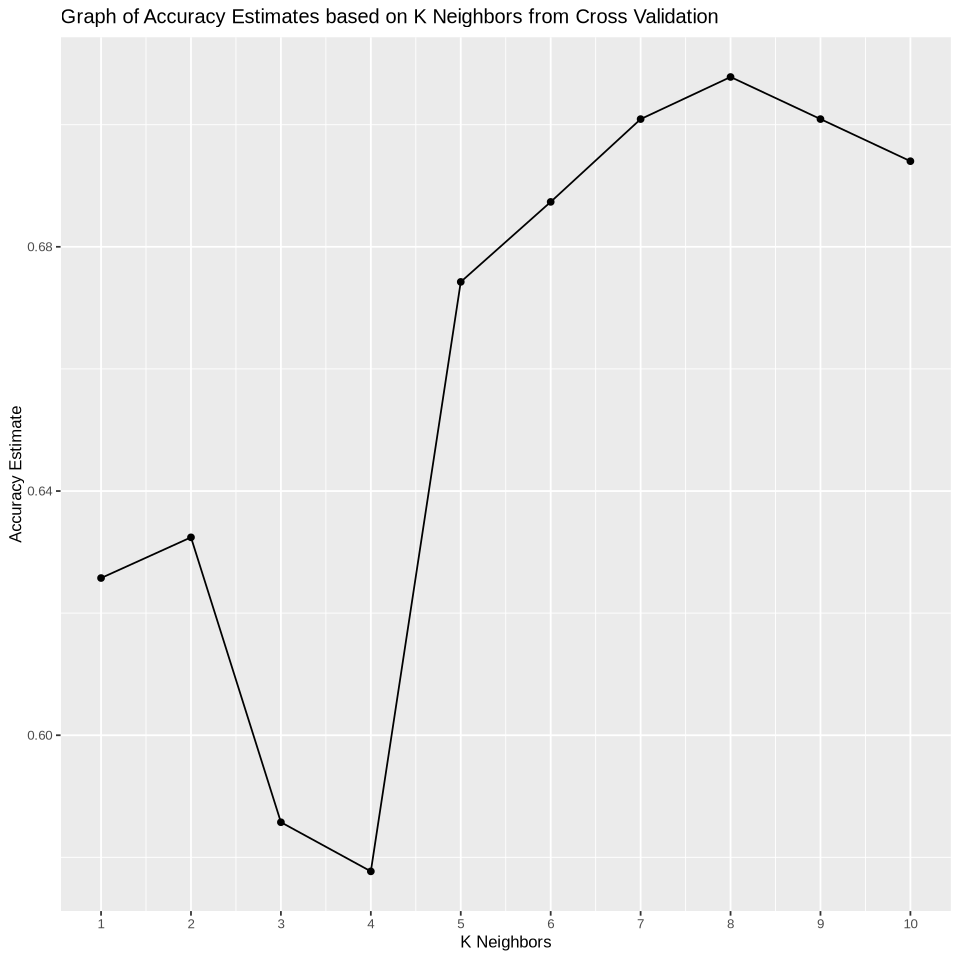

In [16]:
set.seed(1) 
library(tidymodels)

players_tidy <- players_tidy |>
mutate(subscribe = as_factor(subscribe))


initial_split <- initial_split(players_tidy, prop = 0.75)
training_data <- training(initial_split)
testing_data <- testing(initial_split)

players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

players_recipe <- recipe(subscribe ~ played_hours + experience, data = training_data) |>
step_dummy(experience) |>
step_scale(all_predictors()) |>
step_center(all_predictors())

players_vfold <- vfold_cv(training_data, v = 5, strata = subscribe)

k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

players_results <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec) |>
    tune_grid(resamples = players_vfold, grid = k_vals) |>
    collect_metrics()

accuracies <- players_results |>
    filter(.metric == "accuracy")

options(repr.plot.width=8, repr.plot.height=8)

cross_val_plot <- ggplot(accuracies, aes(x=neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    scale_x_continuous (breaks = seq ( 1, 10, by = 1)) + 
    labs(x="K Neighbors", y = "Accuracy Estimate") +
    ggtitle("Graph of Accuracy Estimates based on K Neighbors from Cross Validation") +
    theme(text = element_text(size = 10))

cross_val_plot

In [8]:
# As we can see, the best K-nearest neighbor we found using our cross-validation is 8.
# Now let's adjust our classification using our newfound neighbor!

players_spec_neighbour <- nearest_neighbor(weight_func = "rectangular", neighbors = 8) |>
set_engine("kknn") |>
set_mode("classification")

players_new_result <- workflow() |>
add_model(players_spec_neighbour) |>
add_recipe(players_recipe) |>
fit(training_data)

In [9]:
# Now that we have our classification workflow, let's see how well it predicts on our testing data!

predictions <- predict(players_new_result, testing_data) |>
bind_cols(testing_data)

# Let's see what the dataset looks like:

pred_metrics <- predictions |>
metrics(truth = subscribe, estimate = .pred_class) |>
filter(.metric == "accuracy")

predictions
pred_metrics

.pred_class,experience,played_hours,subscribe
<fct>,<fct>,<dbl>,<fct>
TRUE,Veteran,0.0,FALSE
TRUE,Amateur,0.7,TRUE
TRUE,Regular,0.1,TRUE
TRUE,Amateur,0.0,TRUE
TRUE,Amateur,0.0,FALSE
TRUE,Amateur,0.1,TRUE
FALSE,Veteran,1.6,TRUE
TRUE,Pro,0.0,TRUE
TRUE,Amateur,48.4,TRUE


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7755102


In [17]:
# An accuracy of 78% is not bad, though from the table above, we can see that the classifier classified everything as True.
# This could be an issue since we are trying to predict if hours played and experience contribute to a player being subscribed to a
# game-related newsletter, and if the classifier always classifies a player as guaranteed to be subscribed to a game-related newsletter,
# It could produce false positives, as shown in the dataset above.

# Let's look at the confusion matrix metrics:

players_conf_mat <- predictions |>
conf_mat(truth = subscribe, estimate = .pred_class)

players_conf_mat

          Truth
Prediction FALSE TRUE
     FALSE     0    1
     TRUE     10   38

Let our **Positive Case** be TRUE

|                  |          |  Actual Values |                |
|:----------------:|----------|:--------------:|:--------------:|
|                  |          |    Negative    |    Positive    |
|**Predicted Value**  | Negative |  True Negative | False Negative|
|                  | Positive | False Positive | True Positive  |


- A **true negative** is an outcome where the model correctly predicts the negative class.
- A **true Positive** is an outcome where the model correctly predicts the negative class.
- A **false negative** is an outcome where the model incorrectly predicts the negative class.
- A **false Positive** is an outcome where the model incorrectly predicts the negative class.

#### From our confusion matrix, let's calculate the **Precision** and **Recall** of our classification algorithm.

**Precision:** Measures the accuracy of our positive predictions. In other words, of the total positive cases, how many were actually positive?

The formula is:
Precision = True Positive / (False Positive + True Positive)

**Recall:** Measures the model's ability to find all positive instances. In other words, how many True positives did the model identify out of all positive cases?


The formula is:
Recall = True Positive / (False Negative + True Positive)

In [22]:
precision <- round(38 / ( 10 + 38 ), 2)
precision

recall <- round(38 / ( 1 + 38 ),2)
recall

[1] 0.79

[1] 0.97